In [1]:
!pip install yfinance
!pip install ta

     |████████████████████████████████| 5.5MB 10.3MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=8010c431d33b46d48c0ea5416cf4196528ed23fd26c3997e31c304805d7623b2
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
  Created wheel for ta: filename=ta-0.7.0-cp36-none-any.whl size=28718 sha256=42bf8b160d54849836d89727c08d18136752b0cc8041d67e6851d61e34a70d51
  Stored in directory: /root/.cache/pip/wheels/dd/88/30/de9553fb54a474eb7480b937cdbb140bdda613d29cf4da7994
Successfully built ta


In [2]:
import yfinance as yf
import ta
import pandas as pd
from datetime import date, timedelta, datetime
from IPython.display import clear_output

### Set Up Backtesting Context ###

In [3]:
ticker = 'ISF.L'
start_date = '2019-01-01'
end_date = '2019-12-31'

date_fmt = '%Y-%m-%d'

### Compute Buffer ###

In [4]:
start_date_buffer = datetime.strptime(start_date, date_fmt) - timedelta(days=365)
start_date_buffer = start_date_buffer.strftime(date_fmt)
start_date_buffer

'2018-01-01'

### Get the OHLC and Volume ###

In [5]:
df = yf.download(ticker, start=start_date_buffer, end=end_date)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,7.595,7.595,7.531,7.557,6.981853,4357031
2018-01-03,7.569,7.591,7.545,7.571,6.994788,4433794
2018-01-04,7.595,7.602,7.570,7.592,7.014190,4938838
2018-01-05,7.600,7.629,7.591,7.616,7.036364,11376228
2018-01-08,7.616,7.622,7.568,7.578,7.001255,32522135


In [6]:
def get_stock_backtest_data(ticker, start_date, end_date):
  date_fmt = '%Y-%m-%d'

  start_date_buffer = datetime.strptime(start_date, date_fmt) - timedelta(days=365)
  start_date_buffer = start_date_buffer.strftime(date_fmt)

  df = yf.download(ticker, start=start_date_buffer, end=end_date)

  return df

In [7]:
df = get_stock_backtest_data('ISF.L', '2019-01-01', '2019-12-31')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,7.595,7.595,7.531,7.557,6.981853,4357031
2018-01-03,7.569,7.591,7.545,7.571,6.994788,4433794
2018-01-04,7.595,7.602,7.570,7.592,7.014190,4938838
2018-01-05,7.600,7.629,7.591,7.616,7.036364,11376228
2018-01-08,7.616,7.622,7.568,7.578,7.001255,32522135


In [8]:
class StockBacktestData:
  def __init__(self, ticker, start_date, end_date):
    self._ticker = ticker
    self._backtest_start_buffer_days = 365
    self._buffer_days = 90

    init_start_date, init_end_date = self._get_buffer_start_end_dates(start_date, end_date)
    self._data = self._download_stock_backtest_data(self._ticker, init_start_date, init_end_date)

  
  def _get_buffer_start_end_dates(self, start_date, end_date):
    date_fmt = '%Y-%m-%d'
    init_start_date = datetime.strptime(start_date, date_fmt) - timedelta(
        days=(self._backtest_start_buffer_days + self._buffer_days)
        )
    
    init_start_date = init_start_date.strftime(date_fmt)

    init_end_date = datetime.strptime(end_date, date_fmt) + timedelta(days=self._buffer_days)

    if init_end_date > datetime.today():
      init_end_date = datetime.today()

    init_end_date = init_end_date.strftime(date_fmt)

    return init_start_date, init_end_date


  def _get_backtest_start_date(self, start_date):
    date_fmt = '%Y-%m-%d'
    start_date_buffer = datetime.strptime(start_date, date_fmt) - timedelta(
        days=self._backtest_start_buffer_days
        )
    
    start_date_buffer = start_date_buffer.strftime(date_fmt)
    return start_date_buffer


  def _download_stock_backtest_data(self, ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date)
    return df


  def get_stock_backtest_data(self, start_date, end_date):
    start_date_buffer = self._get_backtest_start_date(start_date)
    df = self._data[(self._data.index >= start_date_buffer) & (self._data.index <= end_date)]
    return df.copy()

### K Band First Example

- Long: Close cross below K Band Lower Bound
- Short: Close cross above K Band upper Bound

In [9]:
k_band = ta.volatility.KeltnerChannel(df.High, df.Low, df.Close, 10)

df['K_BAND_UB'] = k_band.keltner_channel_hband().round(4)
df['K_BAND_LB'] = k_band.keltner_channel_lband().round(4)

df[['K_BAND_UB', 'K_BAND_LB']].dropna().head()

,K_BAND_UB,K_BAND_LB
Date,,
2018-01-02,7.6250,7.4970
2018-01-03,7.6200,7.5100
2018-01-04,7.6200,7.5253
2018-01-05,7.6275,7.5375
2018-01-08,7.6307,7.5371


In [10]:
df['CLOSE_PREV'] = df.Close.shift(1)

df['LONG'] = (df.Close <= df.K_BAND_LB) & (df.CLOSE_PREV > df.K_BAND_LB)
df['EXIT_LONG'] = (df.Close >= df.K_BAND_UB) & (df.CLOSE_PREV < df.K_BAND_UB)

df['SHORT'] = (df.Close >= df.K_BAND_UB) & (df.CLOSE_PREV < df.K_BAND_UB)
df['EXIT_SHORT'] = (df.Close <= df.K_BAND_LB) & (df.CLOSE_PREV > df.K_BAND_LB)

df.LONG = df.LONG.shift(1)
df.EXIT_LONG = df.EXIT_LONG.shift(1)
df.SHORT = df.SHORT.shift(1)
df.EXIT_SHORT = df.EXIT_SHORT.shift(1)

df[['LONG', 'EXIT_LONG', 'SHORT', 'EXIT_SHORT']].dropna().head()

,LONG,EXIT_LONG,SHORT,EXIT_SHORT
Date,,,,
2018-01-03,False,False,False,False
2018-01-04,False,False,False,False
2018-01-05,False,False,False,False
2018-01-08,False,False,False,False
2018-01-09,False,False,False,False


In [11]:
def strategy_KeltnerChannel_origin(df, **kwargs):
  n = kwargs.get('n', 10)
  data = df.copy()

  k_band = ta.volatility.KeltnerChannel(data.High, data.Low, data.Close, n)

  data['K_BAND_UB'] = k_band.keltner_channel_hband().round(4)
  data['K_BAND_LB'] = k_band.keltner_channel_lband().round(4)

  data['CLOSE_PREV'] = data.Close.shift(1)
  
  data['LONG'] = (data.Close <= data.K_BAND_LB) & (data.CLOSE_PREV > data.K_BAND_LB)
  data['EXIT_LONG'] = (data.Close >= data.K_BAND_UB) & (data.CLOSE_PREV < data.K_BAND_UB)

  data['SHORT'] = (data.Close >= data.K_BAND_UB) & (data.CLOSE_PREV < data.K_BAND_UB)
  data['EXIT_SHORT'] = (data.Close <= data.K_BAND_LB) & (data.CLOSE_PREV > data.K_BAND_LB)

  data.LONG = data.LONG.shift(1)
  data.EXIT_LONG = data.EXIT_LONG.shift(1)
  data.SHORT = data.SHORT.shift(1)
  data.EXIT_SHORT = data.EXIT_SHORT.shift(1)

  return data


def strategy_KeltnerChannel_origin_long(df, **kwargs):
  n = kwargs.get('n', 10)
  data = df.copy()

  k_band = ta.volatility.KeltnerChannel(data.High, data.Low, data.Close, n)

  data['K_BAND_UB'] = k_band.keltner_channel_hband().round(4)
  data['K_BAND_LB'] = k_band.keltner_channel_lband().round(4)

  data['CLOSE_PREV'] = data.Close.shift(1)
  
  data['LONG'] = (data.Close <= data.K_BAND_LB) & (data.CLOSE_PREV > data.K_BAND_LB)
  data['EXIT_LONG'] = (data.Close >= data.K_BAND_UB) & (data.CLOSE_PREV < data.K_BAND_UB)

  data['SHORT'] = False
  data['EXIT_SHORT'] = False

  data.LONG = data.LONG.shift(1)
  data.EXIT_LONG = data.EXIT_LONG.shift(1)
  
  data.SHORT = data.SHORT.shift(1)
  data.EXIT_SHORT = data.EXIT_SHORT.shift(1)

  return data

In [12]:
df = strategy_KeltnerChannel_origin(df, n=10)
df.head()

,Open,High,Low,Close,Adj Close,Volume,K_BAND_UB,K_BAND_LB,CLOSE_PREV,LONG,EXIT_LONG,SHORT,EXIT_SHORT
Date,,,,,,,,,,,,,
2018-01-02,7.595,7.595,7.531,7.557,6.981853,4357031,7.6250,7.4970,NaN,NaN,NaN,NaN,NaN
2018-01-03,7.569,7.591,7.545,7.571,6.994788,4433794,7.6200,7.5100,7.557,False,False,False,False
2018-01-04,7.595,7.602,7.570,7.592,7.014190,4938838,7.6200,7.5253,7.571,False,False,False,False
2018-01-05,7.600,7.629,7.591,7.616,7.036364,11376228,7.6275,7.5375,7.592,False,False,False,False
2018-01-08,7.616,7.622,7.568,7.578,7.001255,32522135,7.6307,7.5371,7.616,False,False,False,False


### Define more strategies

- Boll 20 2 2
- Simple MA 50
- EMA 50
- MACD 12 26 9
- RSI 14
- WR 14
- Stochastic Fast 20 5 5 3
- Stochastic Slow 20 5 5 3
- Ichimoku 9 26 26 26


In [13]:
def strategy_BollingerBands(df, **kwargs):
  n = kwargs.get('n', 10)
  n_rng = kwargs.get('n_rng', 2)
  data = df.copy()

  boll = ta.volatility.BollingerBands(data.Close, n, n_rng)

  data['BOLL_LBAND_INDI'] = boll.bollinger_lband_indicator()
  data['BOLL_UBAND_INDI'] = boll.bollinger_hband_indicator()

  data['CLOSE_PREV'] = data.Close.shift(1)

  data['LONG'] = data.BOLL_LBAND_INDI == 1
  data['EXIT_LONG'] = data.BOLL_UBAND_INDI == 1

  data['SHORT'] = data.BOLL_UBAND_INDI == 1
  data['EXIT_SHORT'] = data.BOLL_LBAND_INDI == 1

  data.LONG = data.LONG.shift(1)
  data.EXIT_LONG = data.EXIT_LONG.shift(1)
  data.SHORT = data.SHORT.shift(1)
  data.EXIT_SHORT = data.EXIT_SHORT.shift(1)

  return data


def strategy_BollingerBands_long(df, **kwargs):
  n = kwargs.get('n', 10)
  n_rng = kwargs.get('n_rng', 2)
  data = df.copy()
  
  boll = ta.volatility.BollingerBands(data.Close, n, n_rng)

  data['BOLL_LBAND_INDI'] = boll.bollinger_lband_indicator()
  data['BOLL_UBAND_INDI'] = boll.bollinger_hband_indicator()

  data['CLOSE_PREV'] = data.Close.shift(1)

  data['LONG'] = data.BOLL_LBAND_INDI == 1
  data['EXIT_LONG'] = data.BOLL_UBAND_INDI == 1

  data['SHORT'] = False
  data['EXIT_SHORT'] = False

  data.LONG = data.LONG.shift(1)
  data.EXIT_LONG = data.EXIT_LONG.shift(1)

  data.SHORT = data.SHORT.shift(1)
  data.EXIT_SHORT = data.EXIT_SHORT.shift(1)

  return data

# df = get_stock_backtest_data('ISF.L', '2019-01-01', '2019-12-31')
# strategy_BollingerBands(df, n=10, n_rng=2)

In [14]:
def strategy_MA(df, **kwargs):
  n = kwargs.get('n', 50)
  ma_type = kwargs.get('ma_type', 'sma')
  ma_type = ma_type.strip().lower()
  data = df.copy()
  
  if ma_type == 'sma':
    sma = ta.trend.SMAIndicator(data.Close, n)
    data['MA'] = sma.sma_indicator().round(4)
  elif ma_type == 'ema':
    ema = ta.trend.EMAIndicator(data.Close, n)
    data['MA'] = ema.ema_indicator().round(4)

  data['CLOSE_PREV'] = data.Close.shift(1)

  data['LONG'] = (data.Close > data.MA) & (data.CLOSE_PREV <= data.MA)
  data['EXIT_LONG'] = (data.Close < data.MA) & (data.CLOSE_PREV >= data.MA)

  data['SHORT'] = (data.Close < data.MA) & (data.CLOSE_PREV >= data.MA)
  data['EXIT_SHORT'] = (data.Close > data.MA) & (data.CLOSE_PREV <= data.MA)

  data.LONG = data.LONG.shift(1)
  data.EXIT_LONG = data.EXIT_LONG.shift(1)
  data.SHORT = data.SHORT.shift(1)
  data.EXIT_SHORT = data.EXIT_SHORT.shift(1)

  return data


def strategy_MA_long(df, **kwargs):
  n = kwargs.get('n', 50)
  ma_type = kwargs.get('ma_type', 'sma')
  ma_type = ma_type.strip().lower()
  data = df.copy()
  
  if ma_type == 'sma':
    sma = ta.trend.SMAIndicator(data.Close, n)
    data['MA'] = sma.sma_indicator().round(4)
  elif ma_type == 'ema':
    ema = ta.trend.EMAIndicator(data.Close, n)
    data['MA'] = ema.ema_indicator().round(4)

  data['CLOSE_PREV'] = data.Close.shift(1)

  data['LONG'] = (data.Close > data.MA) & (data.CLOSE_PREV <= data.MA)
  data['EXIT_LONG'] = (data.Close < data.MA) & (data.CLOSE_PREV >= data.MA)

  data['SHORT'] = False
  data['EXIT_SHORT'] = False

  data.LONG = data.LONG.shift(1)
  data.EXIT_LONG = data.EXIT_LONG.shift(1)

  data.SHORT = data.SHORT.shift(1)
  data.EXIT_SHORT = data.EXIT_SHORT.shift(1)

  return data


# df = get_stock_backtest_data('ISF.L', '2019-01-01', '2019-12-31')
# strategy_SMA(df, n=10, ma_type='ema')

In [15]:
def strategy_MACD(df, **kwargs):
  n_slow = kwargs.get('n_slow', 26)
  n_fast = kwargs.get('n_fast', 12)
  n_sign = kwargs.get('n_sign', 9)
  data = df.copy()

  macd = ta.trend.MACD(data.Close, n_slow, n_fast, n_sign)

  data['MACD_DIFF'] = macd.macd_diff().round(4)
  data['MACD_DIFF_PREV'] = data.MACD_DIFF.shift(1)

  data['LONG'] = (data.MACD_DIFF > 0) & (data.MACD_DIFF_PREV <= 0)
  data['EXIT_LONG'] = (data.MACD_DIFF < 0) & (data.MACD_DIFF_PREV >= 0)

  data['SHORT'] = (data.MACD_DIFF < 0) & (data.MACD_DIFF_PREV >= 0)
  data['EXIT_SHORT'] = (data.MACD_DIFF > 0) & (data.MACD_DIFF_PREV <= 0)

  data.LONG = data.LONG.shift(1)
  data.EXIT_LONG = data.EXIT_LONG.shift(1)
  data.SHORT = data.SHORT.shift(1)
  data.EXIT_SHORT = data.EXIT_SHORT.shift(1)

  return data


def strategy_MACD_long(df, **kwargs):
  n_slow = kwargs.get('n_slow', 26)
  n_fast = kwargs.get('n_fast', 12)
  n_sign = kwargs.get('n_sign', 9)
  data = df.copy()

  macd = ta.trend.MACD(data.Close, n_slow, n_fast, n_sign)

  data['MACD_DIFF'] = macd.macd_diff().round(4)
  data['MACD_DIFF_PREV'] = data.MACD_DIFF.shift(1)

  data['LONG'] = (data.MACD_DIFF > 0) & (data.MACD_DIFF_PREV <= 0)
  data['EXIT_LONG'] = (data.MACD_DIFF < 0) & (data.MACD_DIFF_PREV >= 0)

  data['SHORT'] = False
  data['EXIT_SHORT'] = False

  data.LONG = data.LONG.shift(1)
  data.EXIT_LONG = data.EXIT_LONG.shift(1)

  data.SHORT = data.SHORT.shift(1)
  data.EXIT_SHORT = data.EXIT_SHORT.shift(1)

  return data

# df = get_stock_backtest_data('ISF.L', '2019-01-01', '2019-12-31')
# strategy_MACD(df, n_slow=26, n_fast=12, n_sign=9)

In [16]:
def strategy_RSI(df, **kwargs):
  n = kwargs.get('n', 14)
  data = df.copy()

  rsi = ta.momentum.RSIIndicator(data.Close, n)

  data['RSI'] = rsi.rsi().round(4)
  data['RSI_PREV'] = data.RSI.shift(1)

  data['LONG'] = (data.RSI > 30) & (data.RSI_PREV <= 30)
  data['EXIT_LONG'] = (data.RSI < 70) & (data.RSI_PREV >= 70)

  data['SHORT'] = (data.RSI < 70) & (data.RSI_PREV >= 70)
  data['EXIT_SHORT'] = (data.RSI > 30) & (data.RSI_PREV <= 30)

  data.LONG = data.LONG.shift(1)
  data.EXIT_LONG = data.EXIT_LONG.shift(1)
  data.SHORT = data.SHORT.shift(1)
  data.EXIT_SHORT = data.EXIT_SHORT.shift(1)

  return data


def strategy_RSI_long(df, **kwargs):
  n = kwargs.get('n', 14)
  data = df.copy()

  rsi = ta.momentum.RSIIndicator(data.Close, n)

  data['RSI'] = rsi.rsi().round(4)
  data['RSI_PREV'] = data.RSI.shift(1)

  data['LONG'] = (data.RSI > 30) & (data.RSI_PREV <= 30)
  data['EXIT_LONG'] = (data.RSI < 70) & (data.RSI_PREV >= 70)

  data['SHORT'] = False
  data['EXIT_SHORT'] = False

  data.LONG = data.LONG.shift(1)
  data.EXIT_LONG = data.EXIT_LONG.shift(1)

  data.SHORT = data.SHORT.shift(1)
  data.EXIT_SHORT = data.EXIT_SHORT.shift(1)

  return data

# df = get_stock_backtest_data('ISF.L', '2019-01-01', '2019-12-31')
# strategy_RSI(df, n_slow=26, n_fast=12, n_sign=9)

In [91]:
def strategy_WR(df, **kwargs):
  n = kwargs.get('n', 14)
  data = df.copy()

  wr = ta.momentum.WilliamsRIndicator(data.High, data.Low, data.Close, n)

  data['WR'] = wr.williams_r().round(4)
  data['WR_PREV'] = data.WR.shift(1)

  data['LONG'] = (data.WR > -80) & (data.WR_PREV <= -80)
  data['EXIT_LONG'] = (data.WR < -20) & (data.WR_PREV >= -20)

  data['SHORT'] = (data.WR < -20) & (data.WR_PREV >= -20)
  data['EXIT_SHORT'] = (data.WR > -80) & (data.WR_PREV <= -80)

  data.LONG = data.LONG.shift(1)
  data.EXIT_LONG = data.EXIT_LONG.shift(1)
  data.SHORT = data.SHORT.shift(1)
  data.EXIT_SHORT = data.EXIT_SHORT.shift(1)

  return data


def strategy_WR_long(df, **kwargs):
  n = kwargs.get('n', 14)
  data = df.copy()

  wr = ta.momentum.WilliamsRIndicator(data.High, data.Low, data.Close, n)

  data['WR'] = wr.williams_r().round(4)
  data['WR_PREV'] = data.WR.shift(1)

  data['LONG'] = (data.WR > -80) & (data.WR_PREV <= -80)
  data['EXIT_LONG'] = (data.WR < -20) & (data.WR_PREV >= -20)

  data['SHORT'] = False
  data['EXIT_SHORT'] = False

  data.LONG = data.LONG.shift(1)
  data.EXIT_LONG = data.EXIT_LONG.shift(1)

  data.SHORT = data.SHORT.shift(1)
  data.EXIT_SHORT = data.EXIT_SHORT.shift(1)

  return data

# df = get_stock_backtest_data('ISF.L', '2019-01-01', '2019-12-31')
# strategy_WR(df, n_slow=26, n_fast=12, n_sign=9)

In [52]:
def strategy_Stochastic_fast(df, **kwargs):
  k = kwargs.get('k', 20)
  d = kwargs.get('d', 5)
  data = df.copy()

  sto = ta.momentum.StochasticOscillator(data.High, data.Low, data.Close, k, d)

  data['K'] = sto.stoch().round(4)
  data['D'] = sto.stoch_signal().round(4)
  data['DIFF'] = data['K'] - data['D']
  data['DIFF_PREV'] = data.DIFF.shift(1)
  
  data['LONG'] = (data.DIFF > 0) & (data.DIFF_PREV <= 0)
  data['EXIT_LONG'] = (data.DIFF < 0) & (data.DIFF_PREV >= 0)

  data['SHORT'] = (data.DIFF < 0) & (data.DIFF_PREV >= 0)
  data['EXIT_SHORT'] = (data.DIFF > 0) & (data.DIFF_PREV <= 0)

  data.LONG = data.LONG.shift(1)
  data.EXIT_LONG = data.EXIT_LONG.shift(1)

  data.SHORT = data.SHORT.shift(1)
  data.EXIT_SHORT = data.EXIT_SHORT.shift(1)

  return data


def strategy_Stochastic_fast_long(df, **kwargs):
  k = kwargs.get('k', 20)
  d = kwargs.get('d', 5)
  data = df.copy()

  sto = ta.momentum.StochasticOscillator(data.High, data.Low, data.Close, k, d)

  data['K'] = sto.stoch().round(4)
  data['D'] = sto.stoch_signal().round(4)
  data['DIFF'] = data['K'] - data['D']
  data['DIFF_PREV'] = data.DIFF.shift(1)
  
  data['LONG'] = (data.DIFF > 0) & (data.DIFF_PREV <= 0)
  data['EXIT_LONG'] = (data.DIFF < 0) & (data.DIFF_PREV >= 0)

  data['SHORT'] = False
  data['EXIT_SHORT'] = False

  data.LONG = data.LONG.shift(1)
  data.EXIT_LONG = data.EXIT_LONG.shift(1)

  data.SHORT = data.SHORT.shift(1)
  data.EXIT_SHORT = data.EXIT_SHORT.shift(1)

  return data

# df = get_stock_backtest_data('ISF.L', '2019-01-01', '2019-12-31')
# strategy_Stochastic_fast(df, k=20, d=5)

In [53]:
def strategy_Stochastic_slow(df, **kwargs):
  k = kwargs.get('k', 20)
  d = kwargs.get('d', 5)
  dd = kwargs.get('dd', 3)
  data = df.copy()

  sto = ta.momentum.StochasticOscillator(data.High, data.Low, data.Close, k, d)

  data['K'] = sto.stoch().round(4)
  data['D'] = sto.stoch_signal().round(4)
  
  ma = ta.trend.SMAIndicator(data.D, dd)
  data['DD'] = ma.sma_indicator().round(4)

  data['DIFF'] = data['D'] - data['DD']
  data['DIFF_PREV'] = data.DIFF.shift(1)
  
  data['LONG'] = (data.DIFF > 0) & (data.DIFF_PREV <= 0)
  data['EXIT_LONG'] = (data.DIFF < 0) & (data.DIFF_PREV >= 0)

  data['SHORT'] = (data.DIFF < 0) & (data.DIFF_PREV >= 0)
  data['EXIT_SHORT'] = (data.DIFF > 0) & (data.DIFF_PREV <= 0)

  data.LONG = data.LONG.shift(1)
  data.EXIT_LONG = data.EXIT_LONG.shift(1)

  data.SHORT = data.SHORT.shift(1)
  data.EXIT_SHORT = data.EXIT_SHORT.shift(1)

  return data


def strategy_Stochastic_slow_long(df, **kwargs):
  k = kwargs.get('k', 20)
  d = kwargs.get('d', 5)
  dd = kwargs.get('dd', 3)
  data = df.copy()

  sto = ta.momentum.StochasticOscillator(data.High, data.Low, data.Close, k, d)

  data['K'] = sto.stoch().round(4)
  data['D'] = sto.stoch_signal().round(4)
  
  ma = ta.trend.SMAIndicator(data.D, dd)
  data['DD'] = ma.sma_indicator().round(4)

  data['DIFF'] = data['D'] - data['DD']
  data['DIFF_PREV'] = data.DIFF.shift(1)
  
  data['LONG'] = (data.DIFF > 0) & (data.DIFF_PREV <= 0)
  data['EXIT_LONG'] = (data.DIFF < 0) & (data.DIFF_PREV >= 0)

  data['SHORT'] = False
  data['EXIT_SHORT'] = False

  data.LONG = data.LONG.shift(1)
  data.EXIT_LONG = data.EXIT_LONG.shift(1)

  data.SHORT = data.SHORT.shift(1)
  data.EXIT_SHORT = data.EXIT_SHORT.shift(1)

  return data

# df = get_stock_backtest_data('ISF.L', '2019-01-01', '2019-12-31')
# strategy_Stochastic_slow(df, k=20, d=5, dd=3)

In [54]:
def strategy_Ichmoku(df, **kwargs):
  n_conv = kwargs.get('n_conv', 9)
  n_base = kwargs.get('n_base', 26)
  n_span_b = kwargs.get('n_span_b', 26)
  data = df.copy()

  ichmoku = ta.trend.IchimokuIndicator(data.High, data.Low, n_conv, n_base, n_span_b)

  data['BASE'] = ichmoku.ichimoku_base_line().round(4)
  data['CONV'] = ichmoku.ichimoku_conversion_line().round(4)

  data['DIFF'] = data['CONV'] - data['BASE']
  data['DIFF_PREV'] = data.DIFF.shift(1)
  
  data['LONG'] = (data.DIFF > 0) & (data.DIFF_PREV <= 0)
  data['EXIT_LONG'] = (data.DIFF < 0) & (data.DIFF_PREV >= 0)

  data['SHORT'] = (data.DIFF < 0) & (data.DIFF_PREV >= 0)
  data['EXIT_SHORT'] = (data.DIFF > 0) & (data.DIFF_PREV <= 0)

  data.LONG = data.LONG.shift(1)
  data.EXIT_LONG = data.EXIT_LONG.shift(1)

  data.SHORT = data.SHORT.shift(1)
  data.EXIT_SHORT = data.EXIT_SHORT.shift(1)

  return data


def strategy_Ichmoku_long(df, **kwargs):
  n_conv = kwargs.get('n_conv', 9)
  n_base = kwargs.get('n_base', 26)
  n_span_b = kwargs.get('n_span_b', 26)
  data = df.copy()

  ichmoku = ta.trend.IchimokuIndicator(data.High, data.Low, n_conv, n_base, n_span_b)

  data['BASE'] = ichmoku.ichimoku_base_line().round(4)
  data['CONV'] = ichmoku.ichimoku_conversion_line().round(4)

  data['DIFF'] = data['CONV'] - data['BASE']
  data['DIFF_PREV'] = data.DIFF.shift(1)
  
  data['LONG'] = (data.DIFF > 0) & (data.DIFF_PREV <= 0)
  data['EXIT_LONG'] = (data.DIFF < 0) & (data.DIFF_PREV >= 0)

  data['SHORT'] = False
  data['EXIT_SHORT'] = False

  data.LONG = data.LONG.shift(1)
  data.EXIT_LONG = data.EXIT_LONG.shift(1)

  data.SHORT = data.SHORT.shift(1)
  data.EXIT_SHORT = data.EXIT_SHORT.shift(1)

  return data

# df = get_stock_backtest_data('ISF.L', '2019-01-01', '2019-12-31')
# strategy_Ichmoku(df, n_conv=9, n_base=26, n_span_b=26)

### Set Up Backtesting Interval ###

In [55]:
bt_df = df[(df.index >= start_date) & (df.index <= end_date)]
bt_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,6.547,6.670,6.522,6.654,6.354484,5107996
2019-01-03,6.610,6.669,6.603,6.610,6.312465,8575653
2019-01-04,6.669,6.762,6.640,6.746,6.442343,4431171
2019-01-07,6.776,6.781,6.693,6.727,6.424198,4629466
2019-01-08,6.720,6.817,6.720,6.775,6.470037,7461453


In [56]:
def prepare_stock_ta_backtest_data(df, start_date, end_date, strategy, **strategy_params):
  df_strategy = strategy(df, **strategy_params)
  bt_df = df_strategy[(df_strategy.index >= start_date) & (df_strategy.index <= end_date)]
  return bt_df

In [57]:
bt_df = prepare_stock_ta_backtest_data(
    df, start_date, end_date, strategy_KeltnerChannel_origin, n=10
    )

bt_df.head()

,Open,High,Low,Close,Adj Close,Volume,K_BAND_UB,K_BAND_LB,CLOSE_PREV,LONG,EXIT_LONG,SHORT,EXIT_SHORT
Date,,,,,,,,,,,,,
2019-01-02,6.547,6.670,6.522,6.654,6.354484,5107996,6.7182,6.5342,6.654,False,False,False,False
2019-01-03,6.610,6.669,6.603,6.610,6.312465,8575653,6.7095,6.5281,6.654,False,False,False,False
2019-01-04,6.669,6.762,6.640,6.746,6.442343,4431171,6.7245,6.5299,6.610,False,False,False,False
2019-01-07,6.776,6.781,6.693,6.727,6.424198,4629466,6.7324,6.5358,6.746,False,True,True,False
2019-01-08,6.720,6.817,6.720,6.775,6.470037,7461453,6.7455,6.5525,6.727,False,False,False,False


### Simulate Trading ###

In [59]:
balance = 1000000
pnl = 0
position = 0

last_signal = 'hold'
last_price = 0
c = 0

trade_date_start = []
trade_date_end = []
trade_days = []
trade_side = []
trade_pnl = []
trade_ret = []

cum_value = []

for index, row in bt_df.iterrows():
    # check and close any positions
    if row.EXIT_LONG and last_signal == 'long':
      trade_date_end.append(row.name)
      trade_days.append(c)

      pnl = (row.Open - last_price) * position
      trade_pnl.append(pnl)
      trade_ret.append((row.Open / last_price - 1) * 100)
      
      balance = balance + row.Open * position
      
      position = 0
      last_signal = 'hold'

      c = 0
    
    elif row.EXIT_SHORT and last_signal == 'short':
      trade_date_end.append(row.name)
      trade_days.append(c)
      
      pnl = (row.Open - last_price) * position
      trade_pnl.append(pnl)
      trade_ret.append((last_price / row.Open - 1) * 100)

      balance = balance + pnl

      position = 0
      last_signal = 'hold'

      c = 0

    # check signal and enter any possible position
    if row.LONG and last_signal != 'long':
      last_signal = 'long'
      last_price = row.Open
      trade_date_start.append(row.name)
      trade_side.append('long')

      position = int(balance / row.Open)
      cost = position * row.Open
      balance = balance - cost

      c = 0

    elif row.SHORT and last_signal != 'short':
      last_signal = 'short'
      last_price = row.Open
      trade_date_start.append(row.name)
      trade_side.append('short')

      position = int(balance / row.Open) * -1
      
      c = 0
      
    # compute market value and count days for any possible poisition
    if last_signal == 'hold':
      market_value = balance
    elif last_signal == 'long':
      c = c + 1
      market_value = position * row.Close + balance
    else: 
      c = c + 1
      market_value = (row.Close - last_price) * position + balance
    
    cum_value.append(market_value)

### Analyze the Result ###

,CUM_RET,BUY_HOLD,ZERO
Date,,,
2019-12-30,41.3,14.25,0


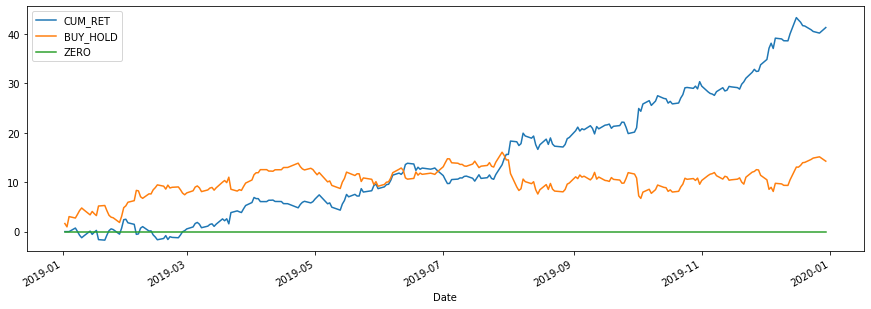

In [60]:
cum_ret_df = pd.DataFrame(cum_value, index=bt_df.index, columns=['CUM_RET'])
cum_ret_df['CUM_RET'] = (cum_ret_df.CUM_RET / 1000000 - 1) * 100
cum_ret_df['BUY_HOLD'] = (bt_df.Close / bt_df.Open.iloc[0] - 1) * 100
cum_ret_df['ZERO'] = 0
cum_ret_df.plot(figsize=(15, 5))

cum_ret_df.iloc[[-1]].round(2)

In [61]:
size = min(len(trade_date_start), len(trade_date_end))

tarde_dict = {
    'START': trade_date_start[:size],
    'END': trade_date_end[:size],
    'SIDE': trade_side[:size],
    'DAYS': trade_days[:size],
    'PNL': trade_pnl[:size],
    'RET': trade_ret[:size]
}

trade_df = pd.DataFrame(tarde_dict)
trade_df.head()

,START,END,SIDE,DAYS,PNL,RET
0,2019-01-07,2019-01-25,short,14,5460.449460,0.549046
1,2019-01-25,2019-01-31,long,4,20888.051224,2.077465
2,2019-01-31,2019-02-28,short,20,-23871.977234,-2.273048
3,2019-02-28,2019-03-19,long,13,22929.104947,2.287254
4,2019-03-19,2019-03-26,short,5,14241.686418,1.408449


In [62]:
num_trades = trade_df.groupby('SIDE').count()[['START']]
num_trades_win = trade_df[trade_df.PNL > 0].groupby('SIDE').count()[['START']]

avg_days = trade_df.groupby('SIDE').mean()[['DAYS']]

avg_ret = trade_df.groupby('SIDE').mean()[['RET']]
avg_ret_win = trade_df[trade_df.PNL > 0].groupby('SIDE').mean()[['RET']]
avg_ret_loss = trade_df[trade_df.PNL < 0].groupby('SIDE').mean()[['RET']]

std_ret = trade_df.groupby('SIDE').std()[['RET']]

detail_df = pd.concat([
                       num_trades, num_trades_win, avg_days,
                       avg_ret, avg_ret_win, avg_ret_loss, std_ret
                       ], axis=1, sort=False)

detail_df.columns = [
                     'NUM_TRADES', 'NUM_TRADES_WIN', 'AVG_DAYS', 
                     'AVG_RET', 'AVG_RET_WIN', 'AVG_RET_LOSS', 'STD_RET'
                     ]

detail_df.round(2)

,NUM_TRADES,NUM_TRADES_WIN,AVG_DAYS,AVG_RET,AVG_RET_WIN,AVG_RET_LOSS,STD_RET
long,10,10,9.4,2.29,2.29,NaN,1.15
short,10,8,14.7,1.42,2.17,-1.57,2.33


### Try Adding Stop Loss ###

In [63]:
balance = 1000000
pnl = 0
position = 0

stop_loss_lvl = -2

last_signal = 'hold'
last_price = 0
c = 0

trade_date_start = []
trade_date_end = []
trade_days = []
trade_side = []
trade_pnl = []
trade_ret = []

cum_value = []

for index, row in bt_df.iterrows():
    # check and close any positions
    if row.EXIT_LONG and last_signal == 'long':
      trade_date_end.append(row.name)
      trade_days.append(c)

      pnl = (row.Open - last_price) * position
      trade_pnl.append(pnl)
      trade_ret.append((row.Open / last_price - 1) * 100)
      
      balance = balance + row.Open * position
      
      position = 0
      last_signal = 'hold'

      c = 0
    
    elif row.EXIT_SHORT and last_signal == 'short':
      trade_date_end.append(row.name)
      trade_days.append(c)
      
      pnl = (row.Open - last_price) * position
      trade_pnl.append(pnl)
      trade_ret.append((last_price / row.Open - 1) * 100)

      balance = balance + pnl

      position = 0
      last_signal = 'hold'

      c = 0


    # check signal and enter any possible position
    if row.LONG and last_signal != 'long':
      last_signal = 'long'
      last_price = row.Open
      trade_date_start.append(row.name)
      trade_side.append('long')

      position = int(balance / row.Open)
      cost = position * row.Open
      balance = balance - cost

      c = 0

    elif row.SHORT and last_signal != 'short':
      last_signal = 'short'
      last_price = row.Open
      trade_date_start.append(row.name)
      trade_side.append('short')

      position = int(balance / row.Open) * -1
      
      c = 0
    

    # check stop loss
    if last_signal == 'long' and c > 0 and (row.Low / last_price - 1) * 100 <= stop_loss_lvl:
      c = c + 1

      trade_date_end.append(row.name)
      trade_days.append(c)

      stop_loss_price = last_price + round(last_price * (stop_loss_lvl / 100), 4)

      pnl = (stop_loss_price - last_price) * position
      trade_pnl.append(pnl)
      trade_ret.append((stop_loss_price / last_price - 1) * 100)
      
      balance = balance + stop_loss_price * position
      
      position = 0
      last_signal = 'hold'

      c = 0

    elif last_signal == 'short' and c > 0 and (last_price / row.High - 1) * 100 <= stop_loss_lvl:
      c = c + 1

      trade_date_end.append(row.name)
      trade_days.append(c)
      
      stop_loss_price = last_price - round(last_price * (stop_loss_lvl / 100), 4)

      pnl = (stop_loss_price - last_price) * position
      trade_pnl.append(pnl)
      trade_ret.append((last_price / stop_loss_price - 1) * 100)

      balance = balance + pnl

      position = 0
      last_signal = 'hold'

      c = 0


    # compute market value and count days for any possible poisition
    if last_signal == 'hold':
      market_value = balance
    elif last_signal == 'long':
      c = c + 1
      market_value = position * row.Close + balance
    else: 
      c = c + 1
      market_value = (row.Close - last_price) * position + balance
    
    cum_value.append(market_value)

### Analyze the Result ###

,CUM_RET,BUY_HOLD,ZERO
Date,,,
2019-12-30,33.3,14.25,0


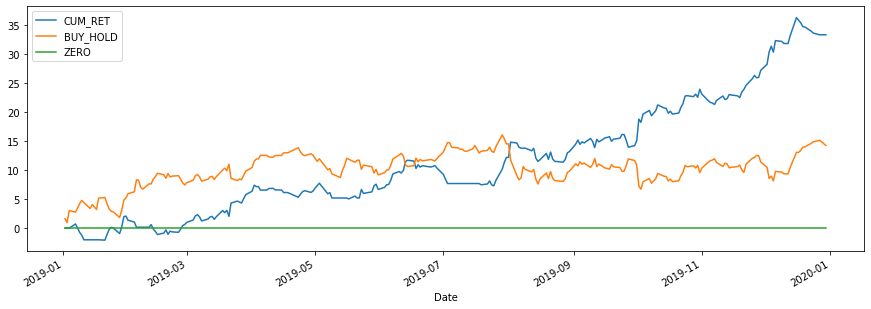

In [64]:
cum_ret_df = pd.DataFrame(cum_value, index=bt_df.index, columns=['CUM_RET'])
cum_ret_df['CUM_RET'] = (cum_ret_df.CUM_RET / 1000000 - 1) * 100
cum_ret_df['BUY_HOLD'] = (bt_df.Close / bt_df.Open.iloc[0] - 1) * 100
cum_ret_df['ZERO'] = 0
cum_ret_df.plot(figsize=(15, 5))

cum_ret_df.iloc[[-1]].round(2)

In [65]:
size = min(len(trade_date_start), len(trade_date_end))

tarde_dict = {
    'START': trade_date_start[:size],
    'END': trade_date_end[:size],
    'SIDE': trade_side[:size],
    'DAYS': trade_days[:size],
    'PNL': trade_pnl[:size],
    'RET': trade_ret[:size]
}

trade_df = pd.DataFrame(tarde_dict)
trade_df.head()

,START,END,SIDE,DAYS,PNL,RET
0,2019-01-07,2019-01-11,short,5,-19996.954500,-1.960501
1,2019-01-21,2019-01-25,short,4,21338.413567,2.225851
2,2019-01-25,2019-01-31,long,4,20802.511014,2.077465
3,2019-01-31,2019-02-05,short,4,-20445.846400,-1.961064
4,2019-02-12,2019-02-28,short,12,5378.611118,0.539851


In [66]:
num_trades = trade_df.groupby('SIDE').count()[['START']]
num_trades_win = trade_df[trade_df.PNL > 0].groupby('SIDE').count()[['START']]

avg_days = trade_df.groupby('SIDE').mean()[['DAYS']]

avg_ret = trade_df.groupby('SIDE').mean()[['RET']]
avg_ret_win = trade_df[trade_df.PNL > 0].groupby('SIDE').mean()[['RET']]
avg_ret_loss = trade_df[trade_df.PNL < 0].groupby('SIDE').mean()[['RET']]

std_ret = trade_df.groupby('SIDE').std()[['RET']]

detail_df = pd.concat([
                       num_trades, num_trades_win, avg_days,
                       avg_ret, avg_ret_win, avg_ret_loss, std_ret
                       ], axis=1, sort=False)

detail_df.columns = [
                     'NUM_TRADES', 'NUM_TRADES_WIN', 'AVG_DAYS', 
                     'AVG_RET', 'AVG_RET_WIN', 'AVG_RET_LOSS', 'STD_RET'
                     ]

detail_df.round(2)

,NUM_TRADES,NUM_TRADES_WIN,AVG_DAYS,AVG_RET,AVG_RET_WIN,AVG_RET_LOSS,STD_RET
SIDE,,,,,,,
long,12,9,7.25,1.56,2.75,-2.00,2.22
short,14,9,9.57,0.84,2.39,-1.96,2.50


### Maximum Drawdown ###

In [67]:
mv_df = pd.DataFrame(cum_value, index=bt_df.index, columns=['MV'])
mv_df.head()

,MV
Date,
2019-01-02,1.000000e+06
2019-01-03,1.000000e+06
2019-01-04,1.000000e+06
2019-01-07,1.007231e+06
2019-01-08,1.000148e+06


In [68]:
days = len(mv_df)

roll_max = mv_df.MV.rolling(window=days, min_periods=1).max()
drawdown_val = mv_df.MV - roll_max
drawdown_pct = (mv_df.MV / roll_max - 1) * 100

print("Max Drawdown Value:", round(drawdown_val.min(), 0))
print("Max Drawdown %:", round(drawdown_pct.min(), 2))

Max Drawdown Value: -44100.0
Max Drawdown %: -3.95


In [69]:
def run_stock_ta_backtest(bt_df, stop_loss_lvl=None):
  balance = 1000000
  pnl = 0
  position = 0

  last_signal = 'hold'
  last_price = 0
  c = 0

  trade_date_start = []
  trade_date_end = []
  trade_days = []
  trade_side = []
  trade_pnl = []
  trade_ret = []

  cum_value = []

  for index, row in bt_df.iterrows():
      # check and close any positions
      if row.EXIT_LONG and last_signal == 'long':
        trade_date_end.append(row.name)
        trade_days.append(c)

        pnl = (row.Open - last_price) * position
        trade_pnl.append(pnl)
        trade_ret.append((row.Open / last_price - 1) * 100)
        
        balance = balance + row.Open * position
        
        position = 0
        last_signal = 'hold'

        c = 0
      
      elif row.EXIT_SHORT and last_signal == 'short':
        trade_date_end.append(row.name)
        trade_days.append(c)
        
        pnl = (row.Open - last_price) * position
        trade_pnl.append(pnl)
        trade_ret.append((last_price / row.Open - 1) * 100)

        balance = balance + pnl

        position = 0
        last_signal = 'hold'

        c = 0


      # check signal and enter any possible position
      if row.LONG and last_signal != 'long':
        last_signal = 'long'
        last_price = row.Open
        trade_date_start.append(row.name)
        trade_side.append('long')

        position = int(balance / row.Open)
        cost = position * row.Open
        balance = balance - cost

        c = 0

      elif row.SHORT and last_signal != 'short':
        last_signal = 'short'
        last_price = row.Open
        trade_date_start.append(row.name)
        trade_side.append('short')

        position = int(balance / row.Open) * -1
        
        c = 0
      
      if stop_loss_lvl:
        # check stop loss
        if last_signal == 'long' and (row.Low / last_price - 1) * 100 <= stop_loss_lvl:
          c = c + 1

          trade_date_end.append(row.name)
          trade_days.append(c)

          stop_loss_price = last_price + round(last_price * (stop_loss_lvl / 100), 4)

          pnl = (stop_loss_price - last_price) * position
          trade_pnl.append(pnl)
          trade_ret.append((stop_loss_price / last_price - 1) * 100)
          
          balance = balance + stop_loss_price * position
          
          position = 0
          last_signal = 'hold'

          c = 0

        elif last_signal == 'short' and (last_price / row.Low - 1) * 100 <= stop_loss_lvl:
          c = c + 1

          trade_date_end.append(row.name)
          trade_days.append(c)
          
          stop_loss_price = last_price - round(last_price * (stop_loss_lvl / 100), 4)

          pnl = (stop_loss_price - last_price) * position
          trade_pnl.append(pnl)
          trade_ret.append((last_price / stop_loss_price - 1) * 100)

          balance = balance + pnl

          position = 0
          last_signal = 'hold'

          c = 0

    
      # compute market value and count days for any possible poisition
      if last_signal == 'hold':
        market_value = balance
      elif last_signal == 'long':
        c = c + 1
        market_value = position * row.Close + balance
      else: 
        c = c + 1
        market_value = (row.Close - last_price) * position + balance
      
      cum_value.append(market_value)


  # generate analysis
  # performance over time
  cum_ret_df = pd.DataFrame(cum_value, index=bt_df.index, columns=['CUM_RET'])
  cum_ret_df['CUM_RET'] = (cum_ret_df.CUM_RET / 1000000 - 1) * 100
  cum_ret_df['BUY_HOLD'] = (bt_df.Close / bt_df.Open.iloc[0] - 1) * 100
  cum_ret_df['ZERO'] = 0

  # trade stats
  size = min(len(trade_date_start), len(trade_date_end))

  tarde_dict = {
      'START': trade_date_start[:size],
      'END': trade_date_end[:size],
      'SIDE': trade_side[:size],
      'DAYS': trade_days[:size],
      'PNL': trade_pnl[:size],
      'RET': trade_ret[:size]
  }

  trade_df = pd.DataFrame(tarde_dict)

  num_trades = trade_df.groupby('SIDE').count()[['START']]
  num_trades_win = trade_df[trade_df.PNL > 0].groupby('SIDE').count()[['START']]

  avg_days = trade_df.groupby('SIDE').mean()[['DAYS']]

  avg_ret = trade_df.groupby('SIDE').mean()[['RET']]
  avg_ret_win = trade_df[trade_df.PNL > 0].groupby('SIDE').mean()[['RET']]
  avg_ret_loss = trade_df[trade_df.PNL < 0].groupby('SIDE').mean()[['RET']]

  std_ret = trade_df.groupby('SIDE').std()[['RET']]

  detail_df = pd.concat([
                        num_trades, num_trades_win, avg_days,
                        avg_ret, avg_ret_win, avg_ret_loss, std_ret
                        ], axis=1, sort=False)

  detail_df.columns = [
                      'NUM_TRADES', 'NUM_TRADES_WIN', 'AVG_DAYS', 
                      'AVG_RET', 'AVG_RET_WIN', 'AVG_RET_LOSS', 'STD_RET'
                      ]

  detail_df.round(2)

  # max drawdown
  mv_df = pd.DataFrame(cum_value, index=bt_df.index, columns=['MV'])

  days = len(mv_df)

  roll_max = mv_df.MV.rolling(window=days, min_periods=1).max()
  drawdown_val = mv_df.MV - roll_max
  drawdown_pct = (mv_df.MV / roll_max - 1) * 100

  # return all stats
  return {
      'cum_ret_df': cum_ret_df,
      'max_drawdown': {
          'value': round(drawdown_val.min(), 0), 
          'pct': round(drawdown_pct.min(), 2)
          },
      'trade_stats': detail_df
  }

In [70]:
result = run_stock_ta_backtest(bt_df)

Max Drawdown: -4.05 %


,NUM_TRADES,NUM_TRADES_WIN,AVG_DAYS,AVG_RET,AVG_RET_WIN,AVG_RET_LOSS,STD_RET
long,10,10,9.4,2.287154,2.287154,NaN,1.149753
short,10,8,14.7,1.423340,2.172675,-1.573999,2.329005


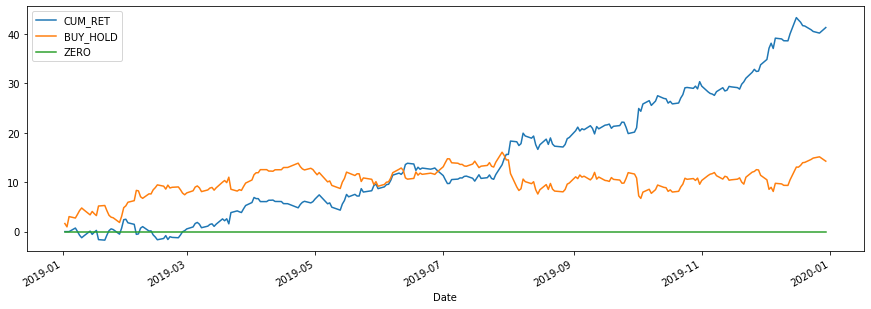

In [71]:
result['cum_ret_df'].plot(figsize=(15, 5))

print('Max Drawdown:', result['max_drawdown']['pct'], '%')

result['trade_stats']

### Put Functinos Together ###

[*********************100%***********************]  1 of 1 completed
Max Drawdown: -4.05 %


,NUM_TRADES,NUM_TRADES_WIN,AVG_DAYS,AVG_RET,AVG_RET_WIN,AVG_RET_LOSS,STD_RET
long,10,10,9.4,2.287154,2.287154,NaN,1.149753
short,10,8,14.7,1.423340,2.172675,-1.573999,2.329005


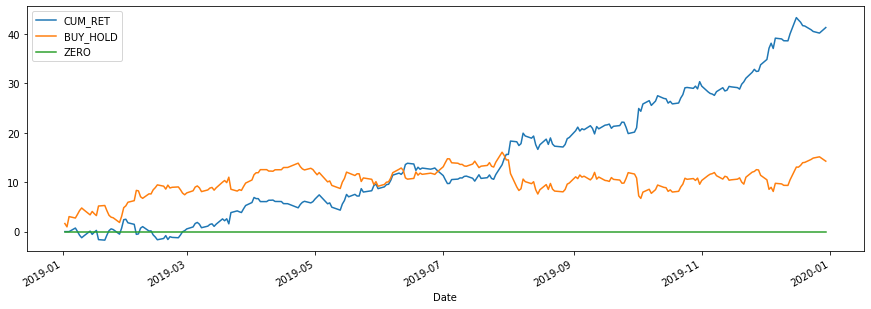

In [72]:
ticker = 'ISF.L'
start_date = '2019-01-01'
end_date = '2019-12-31'

df = get_stock_backtest_data(ticker, start_date, end_date)

bt_df = prepare_stock_ta_backtest_data(
    df, start_date, end_date, 
    strategy_KeltnerChannel_origin, n=10
    )

result = run_stock_ta_backtest(bt_df)

result['cum_ret_df'].plot(figsize=(15, 5))
print('Max Drawdown:', result['max_drawdown']['pct'], '%')
result['trade_stats']

### Try Different Inputs ###

In [73]:
ticker = 'ISF.L'
start_date = '2019-01-01'
end_date = '2019-12-31'

df = get_stock_backtest_data(ticker, start_date, end_date)


n_list = [i for i in range(10, 30, 5)]
stop_loss_lvl = [-i for i in range(2, 5, 1)]
stop_loss_lvl.append(None)

result_dict = {
    'n': [],
    'l': [],
    'return': [],
    'max_drawdown': []
}

for n in n_list:
  for l in stop_loss_lvl:
    bt_df = prepare_stock_ta_backtest_data(
        df, start_date, end_date, 
        strategy_KeltnerChannel_origin, n=n
        )

    result = run_stock_ta_backtest(bt_df, stop_loss_lvl=l)

    result_dict['n'].append(n)
    result_dict['l'].append(l)
    result_dict['return'].append(result['cum_ret_df'].iloc[-1, 0])
    result_dict['max_drawdown'].append(result['max_drawdown']['pct'])


df = pd.DataFrame(result_dict)
df.sort_values('return', ascending=False)

[*********************100%***********************]  1 of 1 completed


,n,l,return,max_drawdown
1,10,-3.0,41.361207,-3.61
2,10,-4.0,41.298869,-4.05
3,10,NaN,41.298869,-4.05
0,10,-2.0,36.672098,-3.61
4,15,-2.0,28.139365,-5.89
6,15,-4.0,27.425182,-5.71
7,15,NaN,27.425182,-5.71
10,20,-4.0,25.034149,-7.16
11,20,NaN,22.976459,-8.69
5,15,-3.0,21.667186,-7.92


### Try Multiple Strategies ###

Key idea

In [74]:
from itertools import product

a = [5, 10]
b = [1, 3]
c = [2, 4]

list(product(a, b, c))

[(5, 1, 2),
 (5, 1, 4),
 (5, 3, 2),
 (5, 3, 4),
 (10, 1, 2),
 (10, 1, 4),
 (10, 3, 2),
 (10, 3, 4)]

In [75]:
param_list = [a, b, c]

list(product(*param_list))

[(5, 1, 2),
 (5, 1, 4),
 (5, 3, 2),
 (5, 3, 4),
 (10, 1, 2),
 (10, 1, 4),
 (10, 3, 2),
 (10, 3, 4)]

In [76]:
def test_func(**kwargs):
  a = kwargs.get('a', 10)
  b = kwargs.get('b', 2)
  c = kwargs.get('c', 2)

  print(a, b, c)


test_func(a=1, b=2, c=3)

1 2 3


In [77]:
param_dict = {'a': 1, 'b': 2, 'c': 3}

test_func(**param_dict)

1 2 3


In [78]:
param_name = ['a', 'b', 'c']
param = [1, 2, 3]

dict(zip(param_name, param))

{'a': 1, 'b': 2, 'c': 3}

In [79]:
dict(zip(['a', 'b', 'c'], [1, 2, 3]))

{'a': 1, 'b': 2, 'c': 3}

In [80]:
a = [5, 10]
b = [1, 3]
c = [2, 4]

param_list = [a, b, c]

param_name = ['a', 'b', 'c']

param_dict_list = [dict(zip(param_name, param)) for param in list(product(*param_list))]

param_dict_list

[{'a': 5, 'b': 1, 'c': 2},
 {'a': 5, 'b': 1, 'c': 4},
 {'a': 5, 'b': 3, 'c': 2},
 {'a': 5, 'b': 3, 'c': 4},
 {'a': 10, 'b': 1, 'c': 2},
 {'a': 10, 'b': 1, 'c': 4},
 {'a': 10, 'b': 3, 'c': 2},
 {'a': 10, 'b': 3, 'c': 4}]

In [81]:
for param_dict in param_dict_list:
  test_func(**param_dict)

5 1 2
5 1 4
5 3 2
5 3 4
10 1 2
10 1 4
10 3 2
10 3 4


- K Band 10
- Boll 20 2
- Simple MA 50
- EMA 50
- MACD 12 26 9
- RSI 14
- WR 14
- Stochastic Fast 20 5
- Stochastic Slow 20 5 3
- Ichimoku 9 26 26

In [82]:
strategies = [
  {
    'func': strategy_KeltnerChannel_origin,
    'param': {
      'n': [i for i in range(10, 35, 5)]
    }
  },

  {
    'func': strategy_BollingerBands,
    'param': {
      'n': [i for i in range(10, 35, 5)],
      'n_rng': [1, 2]
    }
  },

  {
    'func': strategy_MA,
    'param': {
      'n': [i for i in range(10, 110, 10)],
      'ma_type': ['sma', 'ema']
    }
  },

  {
    'func': strategy_MACD,
    'param': {
      'n_slow': [i for i in range(10, 16)],
      'n_fast': [i for i in range(20, 26)],
      'n_sign': [i for i in range(5, 11)]
    }
  },

  {
    'func': strategy_RSI,
    'param': {
      'n': [i for i in range(5, 21)]
    }
  },

  {
    'func': strategy_WR,
    'param': {
      'n': [i for i in range(5, 21)]
    }
  },

  {
    'func': strategy_Stochastic_fast,
    'param': {
      'k': [i for i in range(15, 26)],
      'd': [i for i in range(5, 11)]
    }
  },

  {
    'func': strategy_Stochastic_slow,
    'param': {
      'k': [i for i in range(15, 26)],
      'd': [i for i in range(5, 11)],
      'dd': [i for i in range(1, 6)]
    }
  },

  {
    'func': strategy_Ichmoku,
    'param': {
      'n_conv': [i for i in range(5, 16)],
      'n_base': [i for i in range(20, 36)],
      'n_span_b': [26]
    }
  },
]

In [83]:
for s in strategies:
  func = s['func']
  param = s['param']

  param_name = []
  param_list = []

  for k in param:
    param_name.append(k)
    param_list.append(param[k])

  param_dict_list = [dict(zip(param_name, param)) for param in list(product(*param_list))]
  
  print(len(param_dict_list))

5
10
20
216
16
16
66
330
176


### Testing Multiple Strategies ###

In [84]:
ticker = 'ISF.L'
start_date = '2019-01-01'
end_date = '2019-12-31'

df = get_stock_backtest_data(ticker, start_date, end_date)

stop_loss_lvl = [-i for i in range(2, 6, 1)]
stop_loss_lvl.append(None)

result_dict = {
    'strategy': [],
    'param': [],
    'stoploss': [],
    'return': [],
    'max_drawdown': []
}

[*********************100%***********************]  1 of 1 completed


In [85]:
for s in strategies:
  func = s['func']
  param = s['param']

  strategy_name = str(func).split(' ')[1]

  param_name = []
  param_list = []

  for k in param:
    param_name.append(k)
    param_list.append(param[k])

  param_dict_list = [dict(zip(param_name, param)) for param in list(product(*param_list))]
  total_param_dict = len(param_dict_list)

  c = 0

  for param_dict in param_dict_list:
    clear_output()
    c = c + 1
    print('Running backtest for {} - ({}/{})'.format(strategy_name, c, total_param_dict))

    for l in stop_loss_lvl:
      bt_df = prepare_stock_ta_backtest_data(
          df, start_date, end_date, 
          func, **param_dict)

      result = run_stock_ta_backtest(bt_df, stop_loss_lvl=l)

      result_dict['strategy'].append(strategy_name)
      result_dict['param'].append(str(param_dict))
      result_dict['stoploss'].append(l)
      result_dict['return'].append(result['cum_ret_df'].iloc[-1, 0])
      result_dict['max_drawdown'].append(result['max_drawdown']['pct'])


df = pd.DataFrame(result_dict)
df.sort_values('return', ascending=False).head(10)

Running backtest for strategy_Ichmoku - (176/176)


,strategy,param,stoploss,return,max_drawdown
1,strategy_KeltnerChannel_origin,{'n': 10},-3.0,41.361207,-3.61
4,strategy_KeltnerChannel_origin,{'n': 10},NaN,41.298869,-4.05
2,strategy_KeltnerChannel_origin,{'n': 10},-4.0,41.298869,-4.05
3,strategy_KeltnerChannel_origin,{'n': 10},-5.0,41.298869,-4.05
0,strategy_KeltnerChannel_origin,{'n': 10},-2.0,36.672098,-3.61
1252,strategy_MACD,"{'n_slow': 15, 'n_fast': 25, 'n_sign': 10}",-4.0,32.702212,-4.38
1254,strategy_MACD,"{'n_slow': 15, 'n_fast': 25, 'n_sign': 10}",NaN,32.702212,-4.38
1253,strategy_MACD,"{'n_slow': 15, 'n_fast': 25, 'n_sign': 10}",-5.0,32.702212,-4.38
1132,strategy_MACD,"{'n_slow': 15, 'n_fast': 21, 'n_sign': 10}",-4.0,31.784431,-4.05
1134,strategy_MACD,"{'n_slow': 15, 'n_fast': 21, 'n_sign': 10}",NaN,31.784431,-4.05


### Testing Dynamic Strategy Picking ###

In [86]:
def pick_top_strategy(ticker, start_date, end_date, strategies):
  df = get_stock_backtest_data(ticker, start_date, end_date)

  stop_loss_lvl = [-i for i in range(2, 6, 1)]
  stop_loss_lvl.append(None)

  result_dict = {
      'strategy': [],
      'param': [],
      'stoploss': [],
      'return': [],
      'max_drawdown': []
  }

  for s in strategies:
    func = s['func']
    param = s['param']

    strategy_name = str(func).split(' ')[1]

    param_name = []
    param_list = []

    for k in param:
      param_name.append(k)
      param_list.append(param[k])

    param_dict_list = [dict(zip(param_name, param)) for param in list(product(*param_list))]
    total_param_dict = len(param_dict_list)

    c = 0

    for param_dict in param_dict_list:
      clear_output()
      c = c + 1
      print('Running backtest for {} - ({}/{})'.format(strategy_name, c, total_param_dict))

      for l in stop_loss_lvl:
        bt_df = prepare_stock_ta_backtest_data(
            df, start_date, end_date, 
            func, **param_dict)

        result = run_stock_ta_backtest(bt_df, stop_loss_lvl=l)

        result_dict['strategy'].append(strategy_name)
        result_dict['param'].append(str(param_dict))
        result_dict['stoploss'].append(l)
        result_dict['return'].append(result['cum_ret_df'].iloc[-1, 0])
        result_dict['max_drawdown'].append(result['max_drawdown']['pct'])

  clear_output()

  df = pd.DataFrame(result_dict)
  df = df[df['return'] > 0]
  top_df = df.sort_values(['return', 'max_drawdown'], ascending=[False, False]).head(1).iloc[0]

  if len(top_df):
    return {
        'strategy': eval(top_df['strategy']), 
        'param': eval(top_df['param']), 
        'stoploss': top_df['stoploss']
    }
  else:
    return None


# top_strategy = pick_top_strategy(ticker, start_date, end_date, strategies)

In [87]:
def execute_strategy(ticker, start_date, end_date, strategy, strategy_param, stop_loss):
  df = get_stock_backtest_data(ticker, start_date, end_date)

  bt_df = prepare_stock_ta_backtest_data(
      df, start_date, end_date, 
      strategy, **strategy_param)

  result = run_stock_ta_backtest(bt_df, stop_loss_lvl=l)

  return result


# result = execute_strategy(
#     ticker, start_date, end_date, 
#     top_strategy['strategy'], top_strategy['param'], top_strategy['stoploss']
# )

# result

[*********************100%***********************]  1 of 1 completed


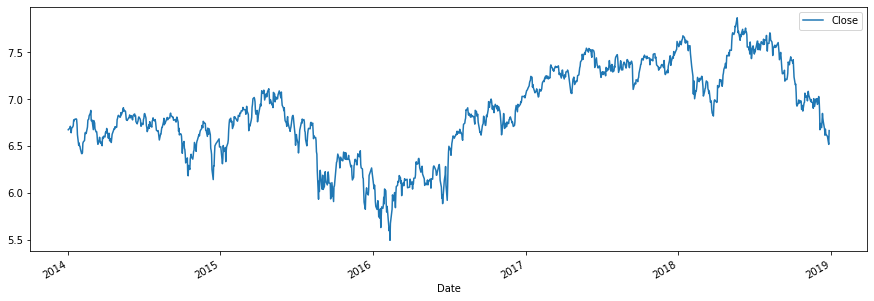

In [88]:
df = get_stock_backtest_data('ISF.L', '2014-12-31', '2018-12-31')
df[['Close']].plot(figsize=(15,5))

In [92]:
strategies = [
  {
    'func': strategy_KeltnerChannel_origin_long,
    'param': {
      'n': [i for i in range(10, 35, 5)]
    }
  },

  {
    'func': strategy_BollingerBands_long,
    'param': {
      'n': [i for i in range(10, 35, 5)],
      'n_rng': [1, 2]
    }
  },

  {
    'func': strategy_MA_long,
    'param': {
      'n': [i for i in range(10, 110, 10)],
      'ma_type': ['sma', 'ema']
    }
  },

  {
    'func': strategy_WR_long,
    'param': {
      'n': [i for i in range(5, 21)]
    }
  },

  {
    'func': strategy_Stochastic_fast_long,
    'param': {
      'k': [i for i in range(15, 26)],
      'd': [i for i in range(5, 11)]
    }
  }
]

In [93]:
top_strategy = pick_top_strategy('ISF.L', '2016-01-01', '2016-12-31', strategies)
top_strategy

{'param': {'n': 10, 'n_rng': 2},
 'stoploss': nan,
 'strategy': <function __main__.strategy_BollingerBands_long>}

[*********************100%***********************]  1 of 1 completed


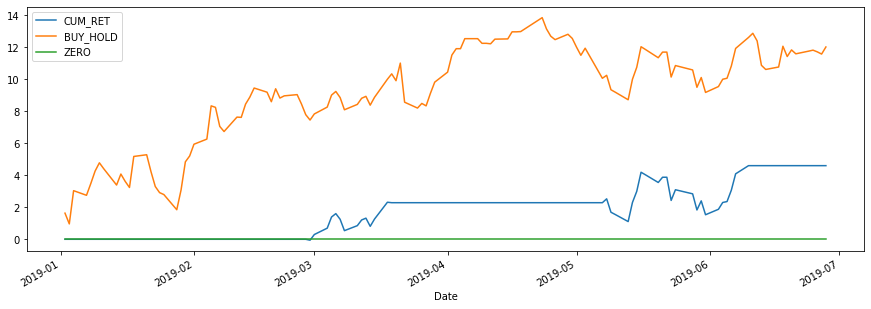

In [94]:
result = execute_strategy(
  'ISF.L', '2019-01-01', '2019-06-30', 
  top_strategy['strategy'], top_strategy['param'], top_strategy['stoploss']
)

result['cum_ret_df'].plot(figsize=(15,5))

In [95]:
result['trade_stats']

,NUM_TRADES,NUM_TRADES_WIN,AVG_DAYS,AVG_RET,AVG_RET_WIN,AVG_RET_LOSS,STD_RET
long,2,2,17.5,2.275411,2.275411,NaN,0.016747


[*********************100%***********************]  1 of 1 completed


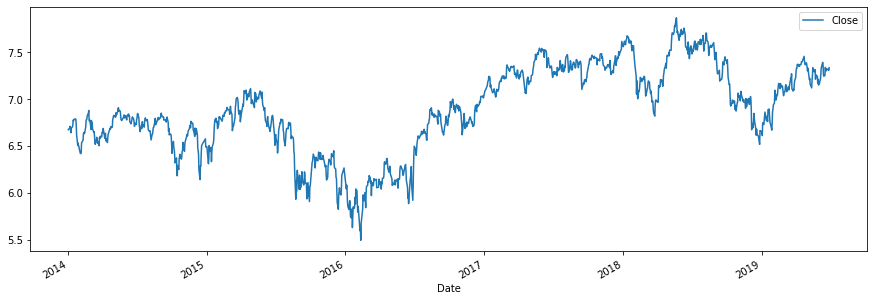

In [96]:
df = get_stock_backtest_data('ISF.L', '2014-12-31', '2019-06-30')
df[['Close']].plot(figsize=(15,5))

In [97]:
strategies = [
  {
    'func': strategy_KeltnerChannel_origin,
    'param': {
      'n': [i for i in range(10, 35, 5)]
    }
  },

  {
    'func': strategy_BollingerBands,
    'param': {
      'n': [i for i in range(10, 35, 5)],
      'n_rng': [1, 2]
    }
  },

  {
    'func': strategy_MA,
    'param': {
      'n': [i for i in range(10, 110, 10)],
      'ma_type': ['sma', 'ema']
    }
  },

  {
    'func': strategy_WR,
    'param': {
      'n': [i for i in range(5, 21)]
    }
  },

  {
    'func': strategy_Stochastic_fast,
    'param': {
      'k': [i for i in range(15, 26)],
      'd': [i for i in range(5, 11)]
    }
  }
]

In [98]:
top_strategy = pick_top_strategy('ISF.L', '2017-06-01', '2017-12-30', strategies)
top_strategy

{'param': {'n': 20, 'n_rng': 1},
 'stoploss': -3.0,
 'strategy': <function __main__.strategy_BollingerBands>}

[*********************100%***********************]  1 of 1 completed


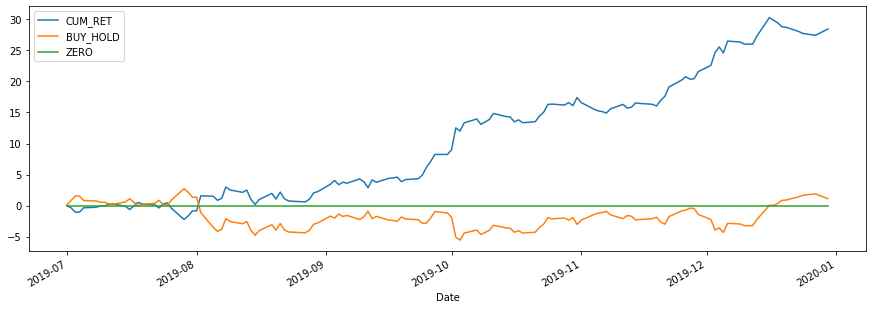

In [99]:
result = execute_strategy(
  'ISF.L', '2019-07-01', '2019-12-31', 
  top_strategy['strategy'], top_strategy['param'], top_strategy['stoploss']
)

result['cum_ret_df'].plot(figsize=(15,5))

In [100]:
result['trade_stats']

,NUM_TRADES,NUM_TRADES_WIN,AVG_DAYS,AVG_RET,AVG_RET_WIN,AVG_RET_LOSS,STD_RET
long,5,5,10.2,2.647828,2.647828,NaN,1.246396
short,5,5,13.6,2.772822,2.772822,NaN,1.276554


### No Silver Bullet ###

In [103]:
top_strategy = pick_top_strategy('ISF.L', '2007-01-01', '2017-12-30', strategies)
top_strategy

{'param': {'n': 20, 'n_rng': 1},
 'stoploss': -2.0,
 'strategy': <function __main__.strategy_BollingerBands>}

[*********************100%***********************]  1 of 1 completed


,NUM_TRADES,NUM_TRADES_WIN,AVG_DAYS,AVG_RET,AVG_RET_WIN,AVG_RET_LOSS,STD_RET
SIDE,,,,,,,
long,5,2,25.000000,-1.329604,0.994348,-2.878906,2.728126
short,6,5,16.833333,0.455967,1.704009,-5.784246,3.159284


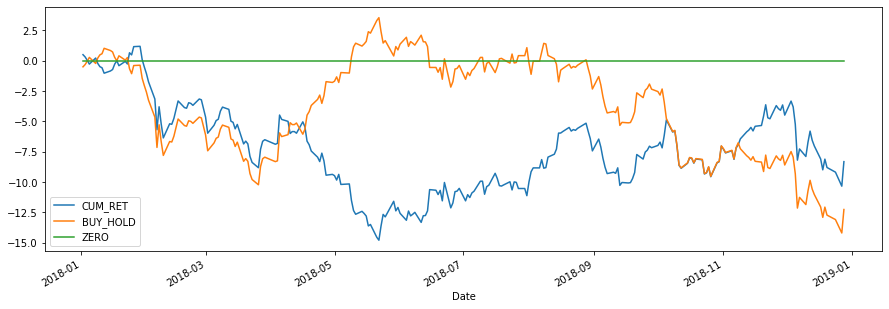

In [104]:
result = execute_strategy(
  'ISF.L', '2018-01-01', '2018-12-31', 
  top_strategy['strategy'], top_strategy['param'], top_strategy['stoploss']
)

result['cum_ret_df'].plot(figsize=(15,5))

result['trade_stats']

[*********************100%***********************]  1 of 1 completed


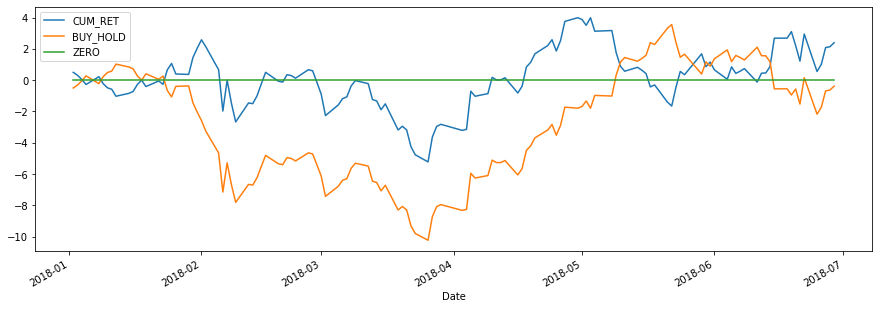

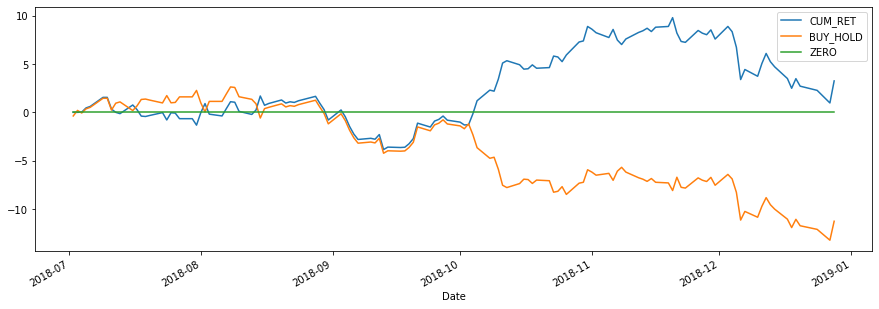

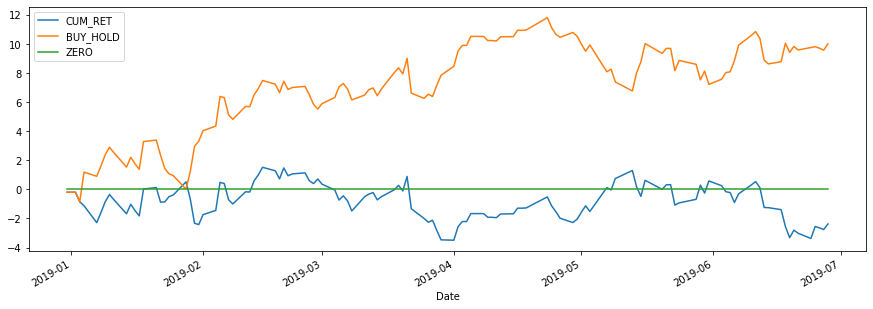

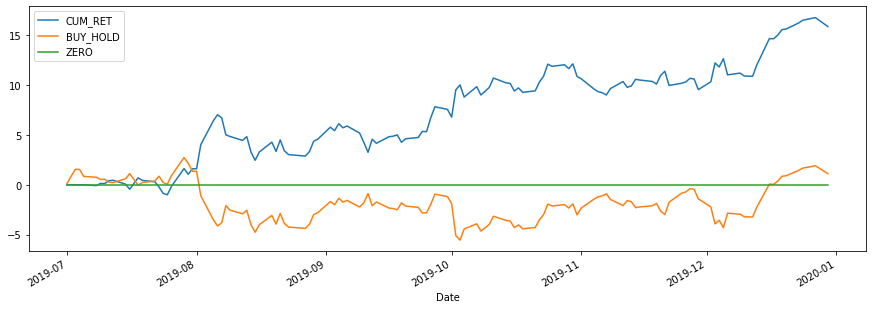

In [113]:
dt_range = pd.date_range('2017-12-31', '2019-12-31', freq='6m')

result_list = []

for i in range(len(dt_range) - 1):
  dt = dt_range[i]
  bt_start = dt - timedelta(days=365)
  bt_end = dt - timedelta(days=1)

  trade_start = dt
  trade_end = dt_range[i+1]

  top_strategy = pick_top_strategy(
      'ISF.L', 
      bt_start.strftime('%Y-%m-%d'), bt_end.strftime('%Y-%m-%d'), 
      strategies
      )

  result = execute_strategy(
    'ISF.L', trade_start.strftime('%Y-%m-%d'), trade_end.strftime('%Y-%m-%d'), 
    top_strategy['strategy'], top_strategy['param'], top_strategy['stoploss']
  )

  result_list.append(result)


for result in result_list:
  result['cum_ret_df'].plot(figsize=(15,5))

### Maybe a Better Way ###